<a href="https://colab.research.google.com/github/VJalili/denovo/blob/main/denovo_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [895]:
# !gcloud init

In [896]:
# !gcloud auth application-default login

## Install Rapids

Install rapids in order to use GPU (e.g., for faster tsne).

Docs: https://docs.rapids.ai/deployment/stable/platforms/colab/

In [897]:
#!nvidia-smi

In [898]:
# !pip uninstall -y pyarrow cudf

In [899]:
# !pip install shap

In [900]:
# Colab warns and provides remediation steps if the GPUs is not compatible with RAPIDS.

# !git clone https://github.com/rapidsai/rapidsai-csp-utils.git
# !python rapidsai-csp-utils/colab/pip-install.py

In [901]:
# !pip install pyarrow==13.0.0

In [902]:
import cudf
import cuml
from cuml.manifold import TSNE as cuml_TSNE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve

from matplotlib.gridspec import GridSpec
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

import os
import pandas as pd
import gzip

from dataclasses import dataclass, field
from google.cloud import storage
from pathlib import Path
from typing import Callable, Any, Dict, Tuple, List

import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import shap

from mpl_toolkits.axes_grid1 import make_axes_locatable

# from sklearn.manifold import TSNE

In [903]:
sns.set_theme()
sns.set_palette(sns.color_palette("tab10"))

In [904]:
data_group = "Non-CNV Only" # @param ["CNV Only","Non-CNV Only","Depth-Only CNV Only","CPX Only"]
base_filename = "GMKF-OFC-GREGoR-denovo-SV-Master-20240918" # @param {"type":"string"}


In [905]:
if data_group == "CNV Only":
  filename = f"{base_filename}_cnv_only.csv"
  data_group_title = "CNV Only"
elif data_group == "Non-CNV Only":
  filename = f"{base_filename}_non_cnv_only.csv"
  data_group_title = "Non-CNV Only"
elif data_group == "Depth-Only CNV Only":
  filename = f"{base_filename}_depth_only_cnv_only.csv"
  data_group_title = "Depth-Only CNV Only"
elif data_group == "CPX Only":
  filename = f"{base_filename}_cpx_only.csv"
  data_group_title = "CPX Only"
else:
  raise ValueError(f"Invalid data group: {data_group}")

# Prepare Data

In [906]:
storage_client = storage.Client(project="broad-dsde-methods")

# This method uses the Google cloud storage library which performs faster
# calling gsutil using `check_output`.
def download_blob(bucket_name, blob_name, local_filename):
  bucket = storage_client.get_bucket(bucket_name)
  blob = bucket.blob(blob_name)
  blob.download_to_filename(local_filename)

def copy_object_to_bucket(bucket_name, blob_name, source_filename):
  bucket = storage_client.get_bucket(bucket_name)
  blob = bucket.blob(blob_name)
  blob.upload_from_filename(source_filename)

In [907]:
working_dir = os.path.join(".", "denovo")
if not os.path.exists(working_dir):
  os.makedirs(working_dir)

In [908]:
bucket_name = "broad-dsde-methods-vj"
base_blob_name = "denovo-sv"
def resolve_filename(filename):
  local_filename = os.path.join(working_dir, filename)
  if True: #not os.path.isfile(local_filename):
    download_blob(bucket_name, f"{base_blob_name}/{filename}", local_filename)
    print(f"Localized {filename}")
  else:
    print(f"File is already localized, filename: {local_filename}")
  return local_filename

denovo_svs_filename = resolve_filename(filename)

Localized GMKF-OFC-GREGoR-denovo-SV-Master-20240918_non_cnv_only.csv


In [909]:
df = pd.read_csv(denovo_svs_filename, sep=",")
df = df.drop(columns=["chrom", "start", "end", "sample"])
df.shape

(3684, 89)

In [910]:
cols_with_nan = []
for column in df.columns:
  nan_count = df[column].isna().sum()
  if nan_count > 0:
    cols_with_nan.append([column, nan_count])

if len(cols_with_nan) > 0:
  print(f"Columns with NaN values: {cols_with_nan}")
  cols_with_nan_col_name = [x[0] for x in cols_with_nan]
  df.drop(columns=cols_with_nan_col_name, inplace=True)
  print(f"Dropped columns with NaN values. df shape: {df.shape}")
else:
  print("No columns with NaN values")

No columns with NaN values


In [911]:
cols_of_obj_type = df.select_dtypes(include=['object']).columns
if len(cols_of_obj_type) > 0:
  print(f"Columns of object type: {cols_of_obj_type}")
  df.drop(columns=cols_of_obj_type, inplace=True)
  print(f"Dropped columns of object type. df shape: {df.shape}")
else:
  print("No columns of object type")

No columns of object type


In [912]:
df.columns

Index(['AC', 'AN', 'SVLEN', 'AF', 'N_BI_GENOS', 'N_HOMREF', 'N_HET',
       'N_HOMALT', 'FREQ_HOMREF', 'FREQ_HET', 'FREQ_HOMALT', 'MALE_AN',
       'MALE_AC', 'MALE_AF', 'MALE_N_BI_GENOS', 'MALE_N_HOMREF', 'MALE_N_HET',
       'MALE_N_HOMALT', 'MALE_FREQ_HOMREF', 'MALE_FREQ_HET',
       'MALE_FREQ_HOMALT', 'FEMALE_AN', 'FEMALE_AC', 'FEMALE_AF',
       'FEMALE_N_BI_GENOS', 'FEMALE_N_HOMREF', 'FEMALE_N_HET',
       'FEMALE_N_HOMALT', 'FEMALE_FREQ_HOMREF', 'FEMALE_FREQ_HET',
       'FEMALE_FREQ_HOMALT', 'gnomad_v2.1_sv_AF', 'gnomad_v2.1_sv_AFR_AF',
       'gnomad_v2.1_sv_AMR_AF', 'gnomad_v2.1_sv_EAS_AF',
       'gnomad_v2.1_sv_EUR_AF', 'num_children', 'num_parents', 'AF_parents',
       'is_large_cnv', 'is_depth_only', 'is_depth_only_small', 'in_gd',
       'num_parents_family', 'GQ', 'PE_GQ', 'PE_GT', 'SR_GQ', 'SR_GT',
       'paternal_gq', 'maternal_gq', 'paternal_pegq', 'maternal_pegq',
       'paternal_srgq', 'maternal_srgq', 'overlap_parent', 'contains_RD',
       'is_ins_recover', '

In [913]:
df[df.select_dtypes(include='bool').columns] = df.select_dtypes(include='bool').astype(int)

In [914]:
scaler = MinMaxScaler()
ndf = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [915]:
ndf = ndf.astype(np.float32)

In [916]:
x = ndf.drop(columns=["result_final"])
y = ndf["result_final"]

In [917]:
# t-SNE using GPU
gdf = cudf.DataFrame.from_pandas(x)
gpu_matrix = gdf.to_cupy()

tsne_model = cuml_TSNE(method="barnes_hut", random_state=1)
# method
# str ‘fft’, ‘barnes_hut’ or ‘exact’ (default ‘fft’)
# ‘barnes_hut’ and ‘fft’ are fast approximations. ‘exact’ is more accurate but slower.

tsne_results = tsne_model.fit_transform(gpu_matrix)
tsne_results_df = pd.DataFrame(tsne_results.get(), columns=["tsne1", "tsne2"])

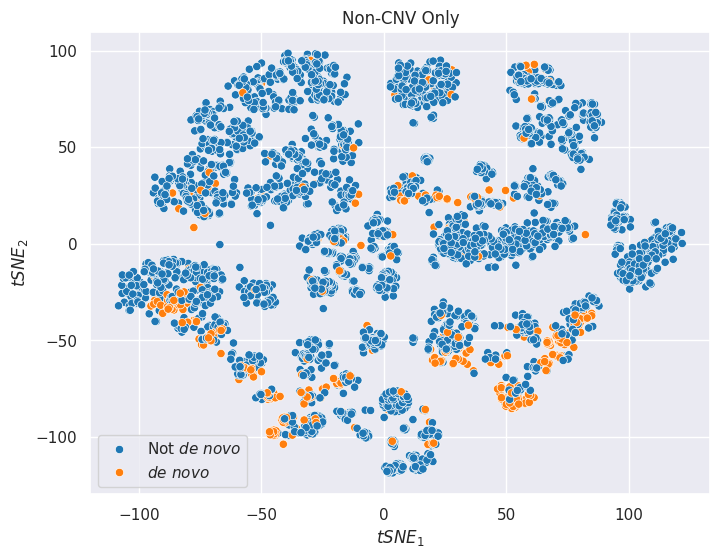

In [918]:
fig, axs = plt.subplots(1, 1, figsize=(8, 6))
sns.scatterplot(data=tsne_results_df, x="tsne1", y="tsne2", hue=y, ax=axs)
axs.set_xlabel(r'$tSNE_1$')
axs.set_ylabel(r'$tSNE_2$')

legend_labels = {0.0: r"Not ${\it de\ novo}$", 1.0: r"${\it de\ novo}$"}
handles, labels = axs.get_legend_handles_labels()
new_labels = [legend_labels[float(label)] for label in labels]
axs.legend(handles, new_labels)
axs.set_title(data_group_title)

plt.show()

In [919]:
x_train, _x_temp, y_train, _y_temp = train_test_split(x, y, test_size=0.3, stratify=y, random_state=1)
x_test, x_dev, y_test, y_dev = train_test_split(_x_temp, _y_temp, test_size=0.6, stratify=_y_temp, random_state=1)

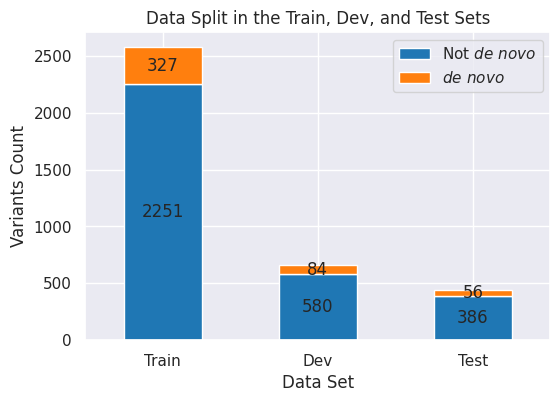

In [920]:
counts_df = pd.DataFrame({
    "set": ["train", "dev", "test"],
    "not de novo": [sum(y_train == 0), sum(y_dev == 0), sum(y_test == 0)],
    "de novo": [sum(y_train == 1), sum(y_dev == 1), sum(y_test == 1)],
})

fig, ax = plt.subplots(figsize=(6, 4))

counts_df.plot(kind='bar', stacked=True, ax=ax)
ax.set_xticklabels(["Train", "Dev", "Test"], rotation=0)

for container in ax.containers:
    ax.bar_label(container, label_type='center')

ax.set_title("Data Split in the Train, Dev, and Test Sets")
ax.set_xlabel("Data Set")
ax.set_ylabel("Variants Count")

legend_labels = {"not de novo": r"Not ${\it de\ novo}$", "de novo": r"${\it de\ novo}$"}
handles, labels = ax.get_legend_handles_labels()
new_labels = [legend_labels[label] for label in labels]
ax.legend(handles, new_labels)

plt.show()

# Helper Methods

In [921]:
disc_col_postfix = "_discretized"
threshold = 0.2
vectorized_discretize = np.vectorize(lambda x: 0 if x < threshold else 1)

def get_thresholds():
  return [round(n, 2) for n in np.linspace(0, 1, num=101, endpoint=True)]

assert threshold in get_thresholds(), f"The provided threshold, {threshold}, is not in the list of thresholds. Either update the threshold or the get_thresholds method to include {threshold}."

In [922]:
models_metrics_df = pd.DataFrame({
    "Model": pd.Series(dtype='str'),
    "Set": pd.Series(dtype='str'),
    'FPR': pd.Series(dtype='float'),
    'TPR': pd.Series(dtype='float'),
    'FNR': pd.Series(dtype='float'),
    'Precision': pd.Series(dtype='float'),
    'FDR': pd.Series(dtype='float'),
    'Accuracy': pd.Series(dtype='float'),
    'F1 Score': pd.Series(dtype='float')
})

In [923]:
def compute_metrics(y_true, y_pred_prob):
  thresholds = get_thresholds()

  fprs = []
  tprs = []
  fnrs = []
  fdrs = []
  accuracys = []
  f1_scores = []
  precisions = []

  for t in thresholds:
      y_pred = (y_pred_prob >= t).astype(int)
      tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

      fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
      tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
      fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
      precision = tp / (tp + fp) if (tp + fp) > 0 else 0
      recall = tpr
      fdr = 1 - precision if (tp + fp) > 0 else 0
      accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
      f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

      fprs.append(fpr)
      tprs.append(tpr)
      fnrs.append(fnr)
      precisions.append(precision)
      fdrs.append(fdr)
      accuracys.append(accuracy)
      f1_scores.append(f1_score)

  metrics_df = pd.DataFrame({
      'Threshold': thresholds,
      'FPR': fprs,
      'TPR': tprs,
      'FNR': fnrs,
      'Precision': precisions,
      'FDR': fdrs,
      'Accuracy': accuracys,
      'F1 Score': f1_scores
  })

  return metrics_df

In [924]:
def evaluate_model(models_metrics_df, model_name, dataset, y_true, y_pred_prob, threshold):

  metrics_df = compute_metrics(y_true, y_pred_prob)
  metrics = metrics_df[metrics_df["Threshold"] == threshold]

  if ((models_metrics_df["Model"] == model_name) & (models_metrics_df["Set"] == dataset)).any() == False:
    mdf = pd.concat([
        models_metrics_df,
        pd.DataFrame({
            "Model": [model_name],
            "Set": [dataset],
            'FPR': [metrics["FPR"].values[0]],
            'TPR': [metrics["TPR"].values[0]],
            'FNR': [metrics["FNR"].values[0]],
            'Precision': [metrics["Precision"].values[0]],
            'FDR': [metrics["FDR"].values[0]],
            'Accuracy': [metrics["Accuracy"].values[0]],
            'F1 Score': [metrics["F1 Score"].values[0]]
            })],
        ignore_index=True)
    return mdf, metrics_df
  else:
    return models_metrics_df, metrics_df

In [925]:
sv_types_columns_with_prefix = [x for x in df.columns if x.startswith("svtype_")]
sv_types_columns = [x.removeprefix("svtype_") for x in sv_types_columns_with_prefix]

In [926]:
print(sv_types_columns)

['ALU', 'CTX', 'INS', 'INV', 'LINE1', 'ME', 'SVA']


In [927]:
def add_confusion_matrix_category(df, true_y_column, pred_y_column):
  conditions = [
    (df[true_y_column] == 1) & (df[pred_y_column] == 1),  # TP
    (df[true_y_column] == 0) & (df[pred_y_column] == 1),  # FP
    (df[true_y_column] == 0) & (df[pred_y_column] == 0),  # TN
    (df[true_y_column] == 1) & (df[pred_y_column] == 0)   # FN
  ]
  categories = ["TP", "FP", "TN", "FN"]
  df["category"] = pd.Categorical(np.select(conditions, categories), categories=categories)
  return df

def rename_svtype_columns(df, svtype_prefix="svtype_"):
  return df.rename(columns={x: x.removeprefix(svtype_prefix) if x.startswith(svtype_prefix) else x for x in df.columns})

In [928]:
def plot_stacked_bar(plot_data_df, datasets, sv_types, title, logscale=True, normalization_method=None):
    fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True)

    cmap = plt.get_cmap("tab10")
    sv_type_colors = {x: cmap(i % cmap.N) for i, x in enumerate(sv_types)}

    category_order = ["TP", "TN", "FP", "FN"]
    x = np.arange(len(category_order))

    for ax, dataset_name in zip(axes, datasets):
        subset = plot_data_df[plot_data_df["dataset"] == dataset_name].set_index("category").reindex(category_order).reset_index()
        bottom = np.zeros(len(subset))

        for sv_type in sv_types:
            ax.bar(x, subset[sv_type], bottom=bottom, color=sv_type_colors[sv_type])
            bottom += subset[sv_type].values

        if logscale and normalization_method is None:
          ax.set_yscale("log")
        ax.set_xticks(x)
        ax.set_xticklabels(category_order)
        ax.set_title(f"{dataset_name} Dataset")
        # ax.set_xlabel("Category")
        if ax == axes[0]:
          if normalization_method is None:
            ax.set_ylabel(f"Count {'(log)' if logscale else ''}")
          else:
            ax.set_ylabel(normalization_method)

    plt.subplots_adjust(bottom=0.2)
    fig.legend(
        [plt.Rectangle((0,0),1,1, color=sv_type_colors[sv_type]) for sv_type in sv_types],
        sv_types,
        title="",
        loc='lower center',
        bbox_to_anchor=(0.5, -0.01),
        ncol=len(sv_types),
        frameon=False
    )

    fig.suptitle(title, fontweight="bold")
    plt.tight_layout(rect=[0, 0.09, 1, 0.98])

    plt.show()

def plot_confusionMatrix_component(preds_train_df, preds_dev_df, preds_test_df, title, y_preds_column_name, logscale=True, normalization_method=None):
  def prepare_data(df, dataset_name):
    df = df.copy()[sv_types_columns_with_prefix + ["y", y_preds_column_name]]
    df = rename_svtype_columns(df)
    df = add_confusion_matrix_category(df, "y", y_preds_column_name)
    plot_data = df.groupby("category", observed=True)[sv_types_columns].sum().reset_index()

    if normalization_method == "Percent by Category":
      total_counts_per_category = df.groupby("category", observed=True).size()
      for col in sv_types_columns:
          plot_data[col] = (plot_data[col] / total_counts_per_category[plot_data["category"]].values)

    plot_data["dataset"] = dataset_name
    return plot_data

  plot_data_df = pd.concat([
    prepare_data(preds_train_df, "Train"),
    prepare_data(preds_dev_df, "Dev"),
    prepare_data(preds_test_df, "Test")
  ])

  plot_stacked_bar(plot_data_df, ["Train", "Dev", "Test"], sv_types_columns, title, logscale, normalization_method)

In [929]:
def plot_stacked_bars_by_svtype(data, datasets, title, logscale=True, normalized=False):
  sv_types = data["sv_type"].unique()
  categories = ["TP", "TN", "FP", "FN"]
  cmap = sns.color_palette("Paired")
  colors = {"TP": cmap[3], "TN": cmap[2], "FP": cmap[8], "FN": cmap[9]}

  num_datasets = len(datasets)
  fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True)

  x = np.arange(len(sv_types))

  for ax, dataset_name in zip(axes, datasets):
    subset = data[data["dataset"] == dataset_name]
    subset = subset.set_index("sv_type").reindex(sv_types).reset_index()

    bottoms = np.zeros(len(sv_types))

    for category in categories:
      counts = subset[category].values
      ax.bar(x, counts, bottom=bottoms, label=category, color=colors.get(category))
      bottoms += counts

    ax.set_xticks(x)
    ax.set_xticklabels(sv_types)
    ax.set_title(f"{dataset_name} Dataset")
    if logscale:
      ax.set_yscale("log")
    if ax == axes[0]:
      if normalized:
        ax.set_ylabel(f"Percentage")
      else:
        ax.set_ylabel(f"Count {'(log)' if logscale else ''}")

  plt.subplots_adjust(bottom=0.25)

  # Create a legend below the plots
  handles = [plt.Rectangle((0,0),1,1, color=colors[category]) for category in categories]
  labels = categories
  fig.legend(
    handles,
    labels,
    # title='',
    loc="lower center",
    bbox_to_anchor=(0.5, -0.05),
    ncol=len(categories),
    frameon=False
  )

  fig.suptitle(title, fontweight="bold")
  plt.tight_layout(rect=[0, 0.08, 1, 0.95])

  plt.show()

def plot_confusionMatrix_component_by_svtype(preds_train_df, preds_dev_df, preds_test_df, title, y_preds_column_name, logscale=True, normalized=False):
  def prepare_data(df, dataset_name):
    df = df.copy()[sv_types_columns_with_prefix + ["y", y_preds_column_name]]
    df = rename_svtype_columns(df)
    df = add_confusion_matrix_category(df, "y", y_preds_column_name)
    data_list = []

    categories = ["TP", "FP", "TN", "FN"]

    for sv_type in sv_types_columns:
      df_sv = df[df[sv_type] == 1]
      counts = df_sv["category"].value_counts().reindex(categories, fill_value=0)

      if normalized:
        counts = (counts / len(df_sv)) * 100

      data = {"sv_type": sv_type, "dataset": dataset_name}
      data.update(counts.to_dict())
      data_list.append(data)

    return pd.DataFrame(data_list)

  plot_data_df = pd.concat([
      prepare_data(predictions_train_df, "Train"),
      prepare_data(predictions_dev_df, "Dev"),
      prepare_data(predictions_test_df, "Test")
      ], ignore_index=True)

  if normalized:
    logscale = False
  plot_stacked_bars_by_svtype(plot_data_df, ["Train", "Dev", "Test"], title, logscale, normalized)

In [930]:
def plot_model_performance(plot_title, model_name, models_metrics_df, train_metrics, dev_metrics, test_metrics, predictions_train_df, predictions_dev_df, predictions_test_df, disc_preds_col_name): # y_true, y_pred_prob): # models_metrics_df, model_metrics_df, y_true, y_pred_prob, cm):

  fig = plt.figure(figsize=(18, 12))
  # gs = GridSpec(3, 3, figure=fig, wspace=0.25, hspace=0.3) #, height_ratios=[3, 1], top=0.85)

  # roc_ax = fig.add_subplot(gs[0, 0])
  # fdr_ax = fig.add_subplot(gs[0, 1])
  # pmt_ax = fig.add_subplot(gs[0, 2]) # pmt: performance metrics vs. thresholds
  # cm_ax = fig.add_subplot(gs[1, 0])
  # tb_ax = fig.add_subplot(gs[1, 1])


  gs = GridSpec(2, 12, figure=fig, wspace=1.5, hspace=0.25) #, height_ratios=[3, 1], top=0.85)

  # First row (span across 7 columns, only use 3 columns)
  roc_ax = fig.add_subplot(gs[0, 0:4])  # First column span (2 columns wide)
  fdr_ax = fig.add_subplot(gs[0, 4:8])  # Second column span (2 columns wide)
  pmt_ax = fig.add_subplot(gs[0, 8:12])  # Third column span (3 columns wide)

  # Second row (4 columns)
  cm_train_ax = fig.add_subplot(gs[1, 0:3])   # First column
  cm_dev_ax = fig.add_subplot(gs[1, 3:6])   # Second column
  cm_test_ax = fig.add_subplot(gs[1, 6:9])    # Third column
  table_ax = fig.add_subplot(gs[1, 9:12])    # Fourth column

  sns.lineplot(data=train_metrics, x="FPR", y="TPR", ax=roc_ax, label=f"Train (AUC={auc(train_metrics['FPR'], train_metrics['TPR']):.2f})")
  sns.lineplot(data=dev_metrics,   x="FPR", y="TPR", ax=roc_ax, label=f"Dev  (AUC={auc(dev_metrics['FPR'],    dev_metrics['TPR']):.2f})")
  sns.lineplot(data=test_metrics,  x="FPR", y="TPR", ax=roc_ax, label=f"Test  (AUC={auc(test_metrics['FPR'],  test_metrics['TPR']):.2f})")
  roc_ax.set_title("ROC Curve")
  roc_ax.set_xlabel("False Positive Rate")
  roc_ax.set_ylabel("True Positive Rate")

  sns.lineplot(data=train_metrics, x="FPR", y="FDR", ax=fdr_ax, label=f"Train (AUC={auc(train_metrics['FPR'], train_metrics['FDR']):.2f})")
  sns.lineplot(data=dev_metrics,   x="FPR", y="FDR", ax=fdr_ax, label=f"Dev  (AUC={auc(dev_metrics['FPR'],    dev_metrics['FDR']):.2f})")
  sns.lineplot(data=test_metrics,  x="FPR", y="FDR", ax=fdr_ax, label=f"Test  (AUC={auc(test_metrics['FPR'],  test_metrics['FDR']):.2f})")
  fdr_ax.set_title("ROC Curve with FDR")
  fdr_ax.set_xlabel("False Positive Rate")
  fdr_ax.set_ylabel("False Discovery Rate")

  sns.lineplot(data=test_metrics, x="Threshold", y="Accuracy",  label="Accuracy",  ax=pmt_ax)
  sns.lineplot(data=test_metrics, x="Threshold", y="Precision", label="Precision", ax=pmt_ax)
  sns.lineplot(data=test_metrics, x="Threshold", y="TPR",       label="Recall",    ax=pmt_ax)
  pmt_ax.set_xlabel("Threshold")
  pmt_ax.set_ylabel("Performance")
  pmt_ax.set_title("Performance Metrics vs. Threshold on Test data")

  def plot_confusion_matrix(cax, yt, yp, title, show_y_labels=True):
    cm = confusion_matrix(yt, yp)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[r"Not ${\it de\ novo}$", "${\it de\ novo}$"])
    im = disp.plot(ax=cax, colorbar=False)

    if not show_y_labels:
      cax.set_yticklabels([])
      cax.set_ylabel('')

    for label in cax.get_yticklabels():
      label.set_rotation(90)
      label.set_verticalalignment('center')
    # ref: https://stackoverflow.com/a/26720422
    cbar = plt.colorbar(im.im_, ax=cax, orientation='horizontal', fraction=0.046, pad=0.2)
    cax.grid(False)
    cax.set_title(title)

  plot_confusion_matrix(cm_train_ax, predictions_train_df["y"], predictions_train_df[disc_preds_col_name], "Confusion Matrix on Train Data")
  plot_confusion_matrix(cm_dev_ax, predictions_dev_df["y"], predictions_dev_df[disc_preds_col_name], "Confusion Matrix on Dev Data")
  plot_confusion_matrix(cm_test_ax, predictions_test_df["y"], predictions_test_df[disc_preds_col_name], "Confusion Matrix on Test Data")

  plt.subplots_adjust(hspace=0.4, wspace=0.4)

  rounded_val_df = models_metrics_df[models_metrics_df["Model"] == model_name].copy().drop(["Model"], axis=1).round(2)
  rounded_val_df.set_index('Set', inplace=True)
  rounded_val_df = rounded_val_df.T

  cellText = []
  for feature_name, row_values in rounded_val_df.iterrows():
      row = [feature_name] + row_values.tolist()
      cellText.append(row)

  colLabels = ['Feature'] + list(rounded_val_df.columns)

  table_width = 0.9
  table_height = 0.8
  table = table_ax.table(
      cellText=cellText,
      colLabels=colLabels,
      loc='center',
      cellLoc='center',
      edges='horizontal',
      bbox=[(1 - table_width) / 2, (1 - table_height) / 2, table_width, table_height]
  )

  table.auto_set_font_size(False)
  table.set_fontsize(10)
  table_ax.axis('off')

  num_cols = len(colLabels)
  num_rows = len(cellText) + 1

  scaling_factor = 0.5
  for key, cell in table.get_celld().items():
      cell_width = (1.0 / num_cols) * scaling_factor
      cell_height = (1.0 / num_rows) * scaling_factor
      cell.set_width(cell_width)
      cell.set_height(cell_height)
      cell.set_text_props(ha='center', va='center')

  for i in range(num_cols):
      cell = table[0, i]
      cell.set_text_props(weight='bold')

  fig.suptitle(f"Model: {plot_title}", fontsize=16, fontweight="bold")

# Random Forest Model

In [931]:
rf_column = "random_forest"
# rfc = RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=12, max_depth=8, min_samples_leaf=1)
rfc = RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=12, oob_score=True, bootstrap=True)
rfc.fit(x_train, y_train)

RandomForestClassifier(n_estimators=1000, n_jobs=-1, oob_score=True,
                       random_state=12)

In [932]:
def get_rf_predictions(x, y):
  rf_preds = rfc.predict_proba(x)[:, 1]
  rf_preds_discretized = vectorized_discretize(rf_preds)

  preds = x.copy()
  preds["y"] = y
  preds[rf_column] = rf_preds
  preds[rf_column + disc_col_postfix] = rf_preds_discretized

  return preds

In [933]:
predictions_train_df = get_rf_predictions(x_train, y_train)
predictions_dev_df = get_rf_predictions(x_dev, y_dev)
predictions_test_df = get_rf_predictions(x_test, y_test)

In [934]:
models_metrics_df, rf_train_metrics = evaluate_model(models_metrics_df, rf_column, "Train", y_train, predictions_train_df[rf_column], threshold)
models_metrics_df, rf_dev_metrics = evaluate_model(models_metrics_df, rf_column, "Dev",   y_dev,   predictions_dev_df[rf_column],   threshold)
models_metrics_df, rf_test_metrics = evaluate_model(models_metrics_df, rf_column, "Test",  y_test,  predictions_test_df[rf_column],  threshold)

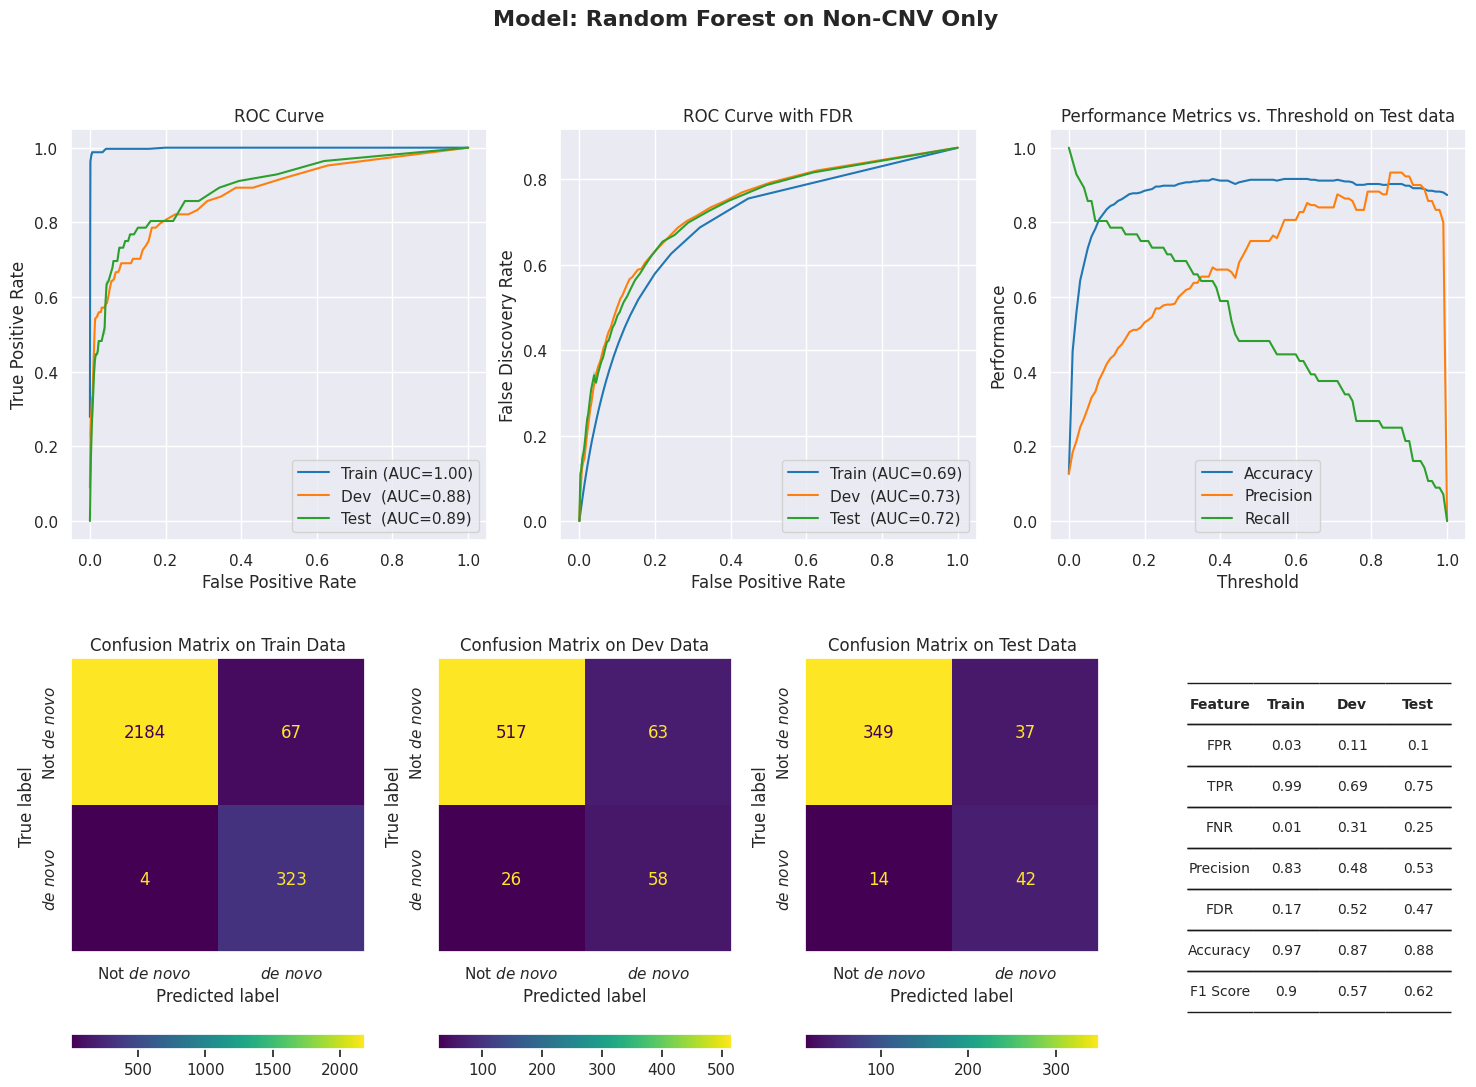

In [935]:
plot_model_performance(f"Random Forest on {data_group_title}", rf_column, models_metrics_df, rf_train_metrics, rf_dev_metrics, rf_test_metrics, predictions_train_df, predictions_dev_df, predictions_test_df, f"{rf_column}{disc_col_postfix}")

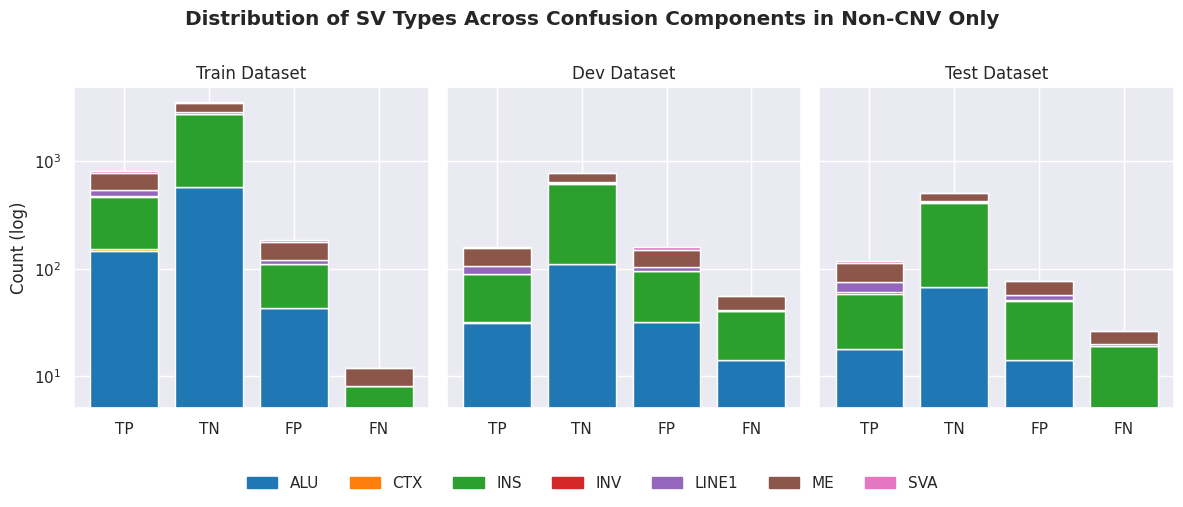

In [936]:
plot_confusionMatrix_component(predictions_train_df, predictions_dev_df, predictions_test_df, f"Distribution of SV Types Across Confusion Components in {data_group_title}", rf_column + disc_col_postfix)

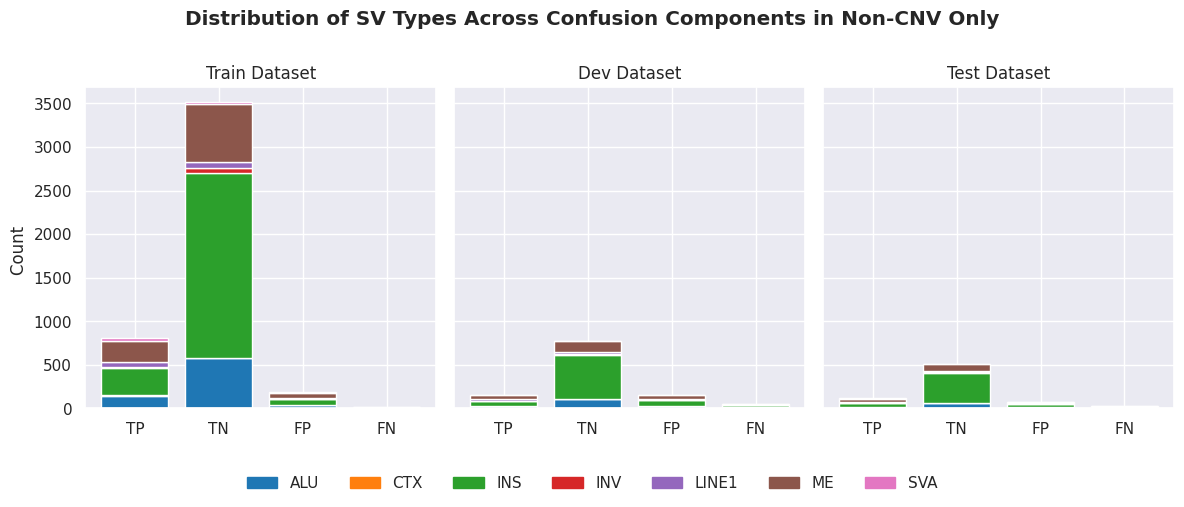

In [937]:
plot_confusionMatrix_component(predictions_train_df, predictions_dev_df, predictions_test_df, f"Distribution of SV Types Across Confusion Components in {data_group_title}", rf_column + disc_col_postfix, logscale=False)

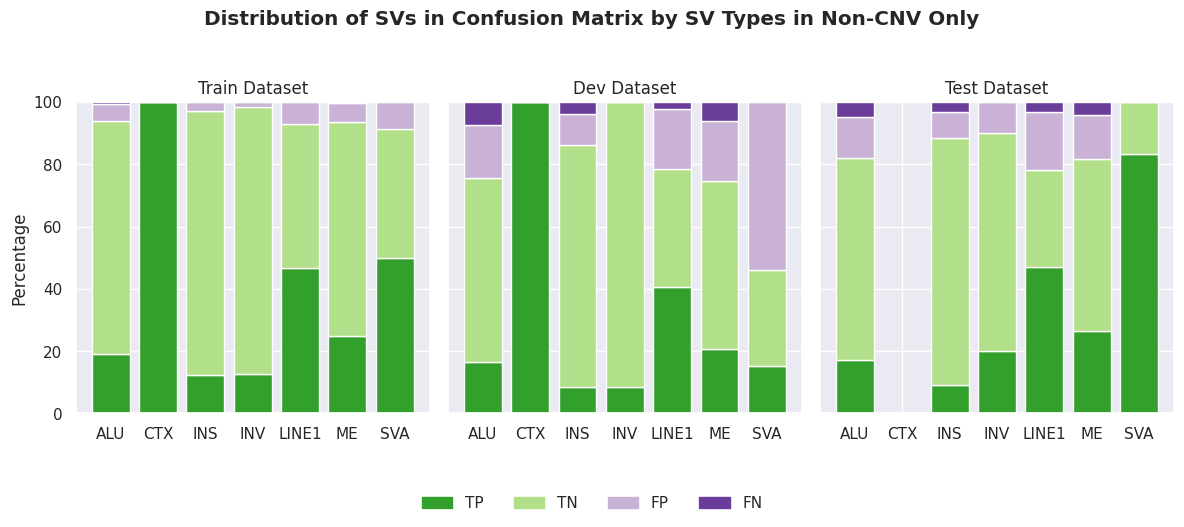

In [938]:
plot_confusionMatrix_component_by_svtype(predictions_train_df, predictions_dev_df, predictions_test_df, f"Distribution of SVs in Confusion Matrix by SV Types in {data_group_title}", rf_column + disc_col_postfix, normalized=True)

In [939]:
predictions_train_df.head()

,AC,AN,SVLEN,AF,N_BI_GENOS,N_HOMREF,N_HET,N_HOMALT,FREQ_HOMREF,FREQ_HET,...,FILTER_UNRESOLVED,GT_0/1,GT_1/1,EVIDENCE_PE,EVIDENCE_SR,EV_PE,EV_SR,y,random_forest,random_forest_discretized
1292,0.2125,1.000000,0.000012,0.211778,1.000000,0.995440,0.222222,0.0,0.788275,0.221442,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.000,0
1213,0.1000,1.000000,0.000005,0.099612,1.000000,0.997854,0.111111,0.0,0.900336,0.110721,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.002,0
1426,0.0000,0.125016,0.000003,0.055726,0.100457,0.101663,0.012346,0.0,0.944225,0.067383,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.006,0
2900,0.1250,0.366427,0.000002,0.323229,0.348644,0.346835,0.135802,0.0,0.676721,0.331597,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.014,0
281,0.4875,0.552188,0.000002,0.844152,0.539619,0.529775,0.493827,0.0,0.155849,0.846040,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.002,0


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


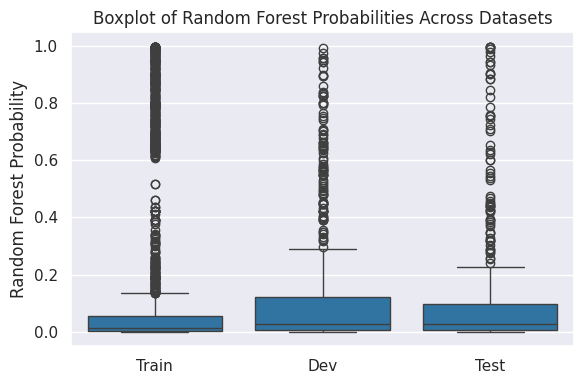

In [957]:
def plot_combined_boxplot(train_df, dev_df, test_df, model_name="Random Forest", prob_col="random_forest"):
    combined_df = pd.concat([
        train_df[[prob_col]].assign(dataset="Train"),
        dev_df[[prob_col]].assign(dataset="Dev"),
        test_df[[prob_col]].assign(dataset="Test")
    ])

    plt.figure(figsize=(6, 4))
    sns.boxplot(x="dataset", y=prob_col, data=combined_df)

    plt.title(f"Boxplot of {model_name} Probabilities Across Datasets")
    plt.xlabel("")
    plt.ylabel(f"{model_name} Probability")
    plt.tight_layout()
    plt.show()

plot_combined_boxplot(predictions_train_df, predictions_dev_df, predictions_test_df)

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future ve

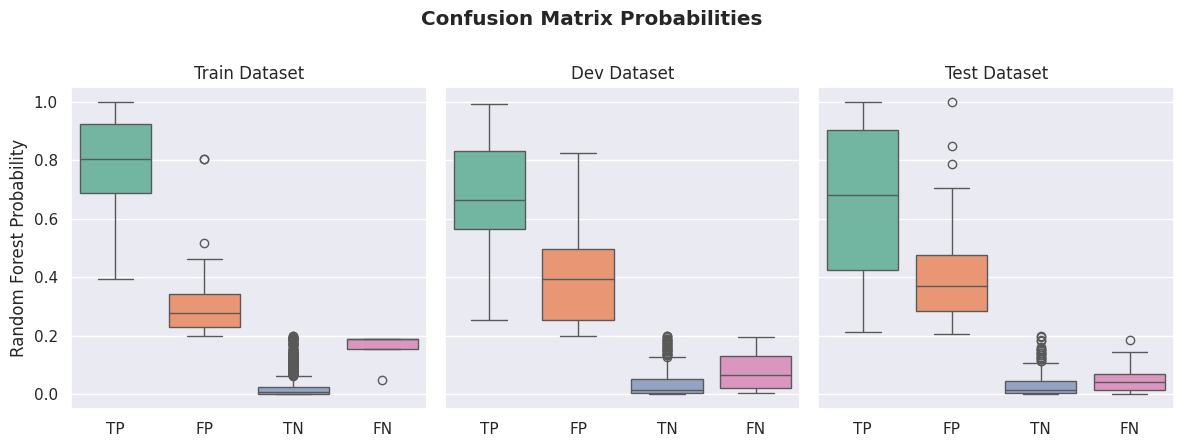

In [961]:
def plot_boxplot(plot_data_df, datasets, title):
    melted_df = plot_data_df.melt(
        id_vars=["category", "dataset"], value_vars=["random_forest"],
                                  var_name='Model', value_name='Probability')

    fig, axes = plt.subplots(1, len(datasets), figsize=(12, 5), sharey=True)

    # Create a boxplot for each dataset in a separate subplot
    for ax, dataset_name in zip(axes, datasets):
        subset = melted_df[melted_df['dataset'] == dataset_name]

        # Plot using 'category' as hue, which will color-code TP, TN, FP, FN
        sns.boxplot(
            x='category', y='Probability', hue='category', data=subset,
            ax=ax, palette="Set2"
        )

        # Set plot title and labels
        ax.set_title(f"{dataset_name} Dataset")
        ax.set_xlabel("")
        ax.set_ylabel("Random Forest Probability" if ax == axes[0] else "")

    # Adjust layout and add a title to the figure
    plt.subplots_adjust(bottom=0.2)
    fig.suptitle(title, fontweight="bold")
    plt.tight_layout(rect=[0, 0.09, 1, 0.98])

    plt.show()

def plot_confusion_probabilities(preds_train_df, preds_dev_df, preds_test_df, title):
  def prepare_data(df, dataset_name):
    df = df.copy()[["y", "random_forest", "random_forest_discretized"]]
    df = add_confusion_matrix_category(df, "y", "random_forest_discretized")

    df["dataset"] = dataset_name
    return df
  plot_data_df = pd.concat([
    prepare_data(preds_train_df, "Train"),
    prepare_data(preds_dev_df, "Dev"),
    prepare_data(preds_test_df, "Test")
  ])

  plot_boxplot(plot_data_df, ["Train", "Dev", "Test"], title)


plot_confusion_probabilities(predictions_train_df, predictions_dev_df, predictions_test_df, "Confusion Matrix Probabilities")


In [942]:
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)

feature_importances_df = pd.DataFrame({
    "feature_importance": rfc.feature_importances_,
    "feature_name": rfc.feature_names_in_,
    "std": std
})

Text(0.5, 0, 'MDI Importance')

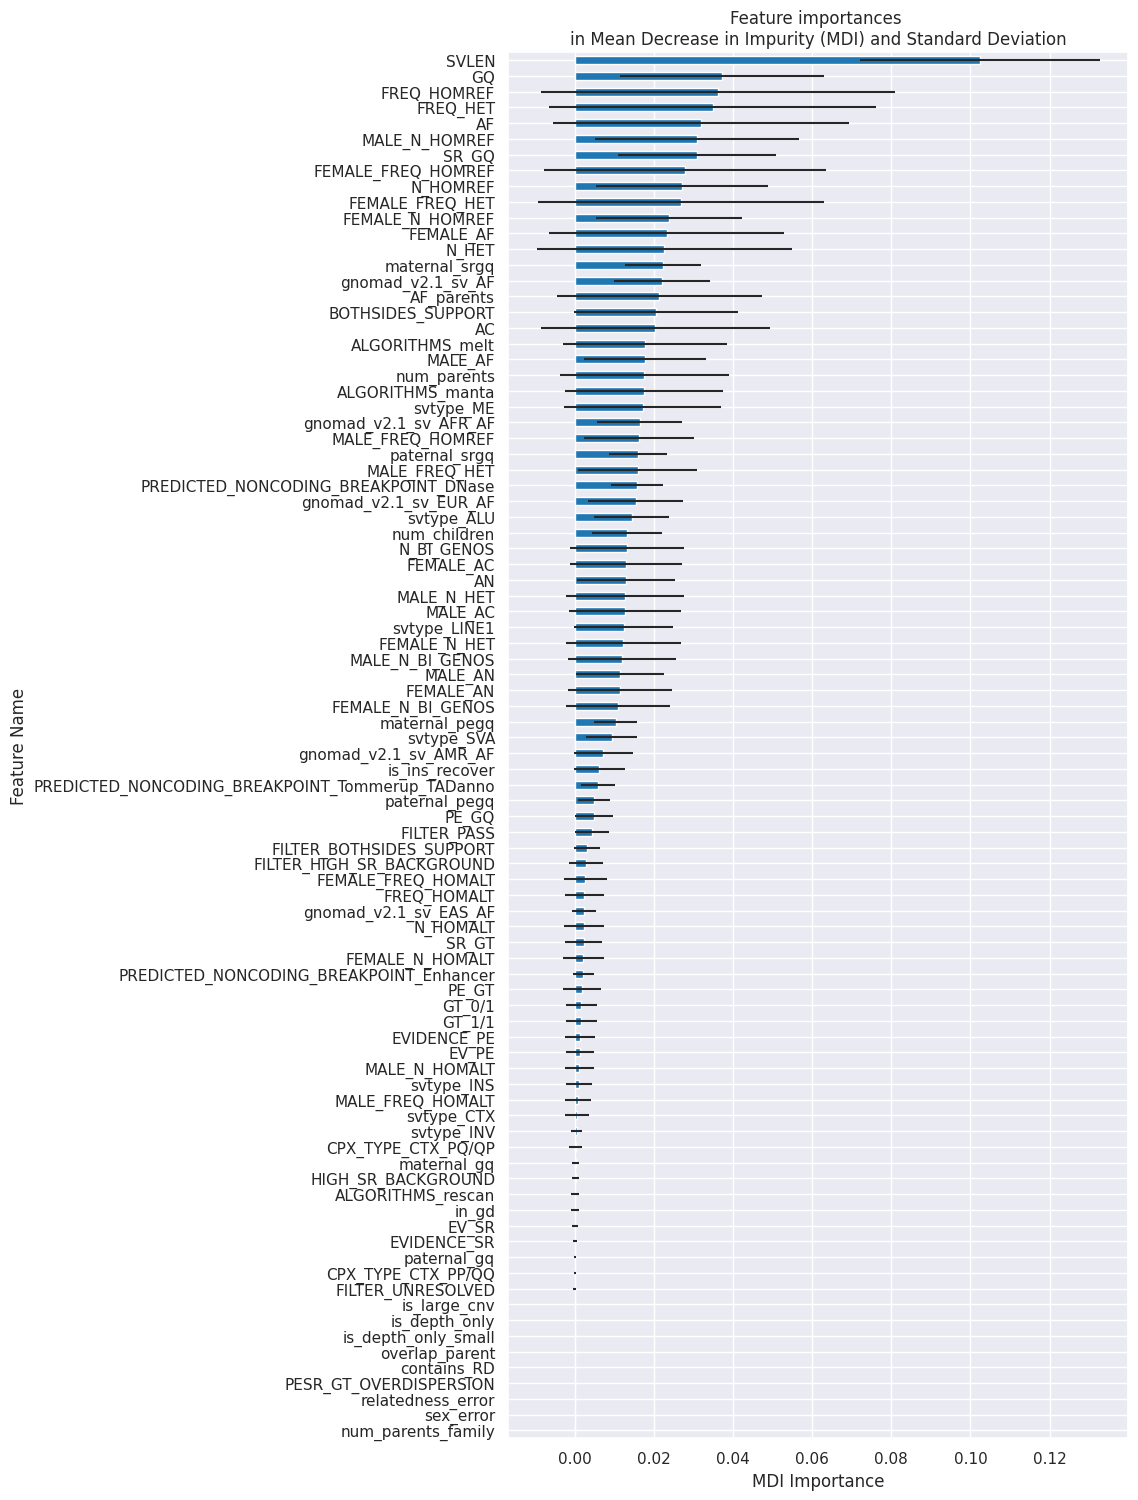

In [943]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8, 18))
feature_importances_df = feature_importances_df.sort_values(by="feature_importance", ascending=True)
feature_importances_df.plot(x="feature_name", y="feature_importance", xerr="std", ax=ax, kind="barh", legend=False)
ax.set_title("Feature importances \nin Mean Decrease in Impurity (MDI) and Standard Deviation")
ax.set_ylabel("Feature Name")
ax.set_xlabel("MDI Importance")

Text(0.5, 1.0, 'Feature Importance in Mean Decrease in Impurity (MDI) and Standard Deviation')

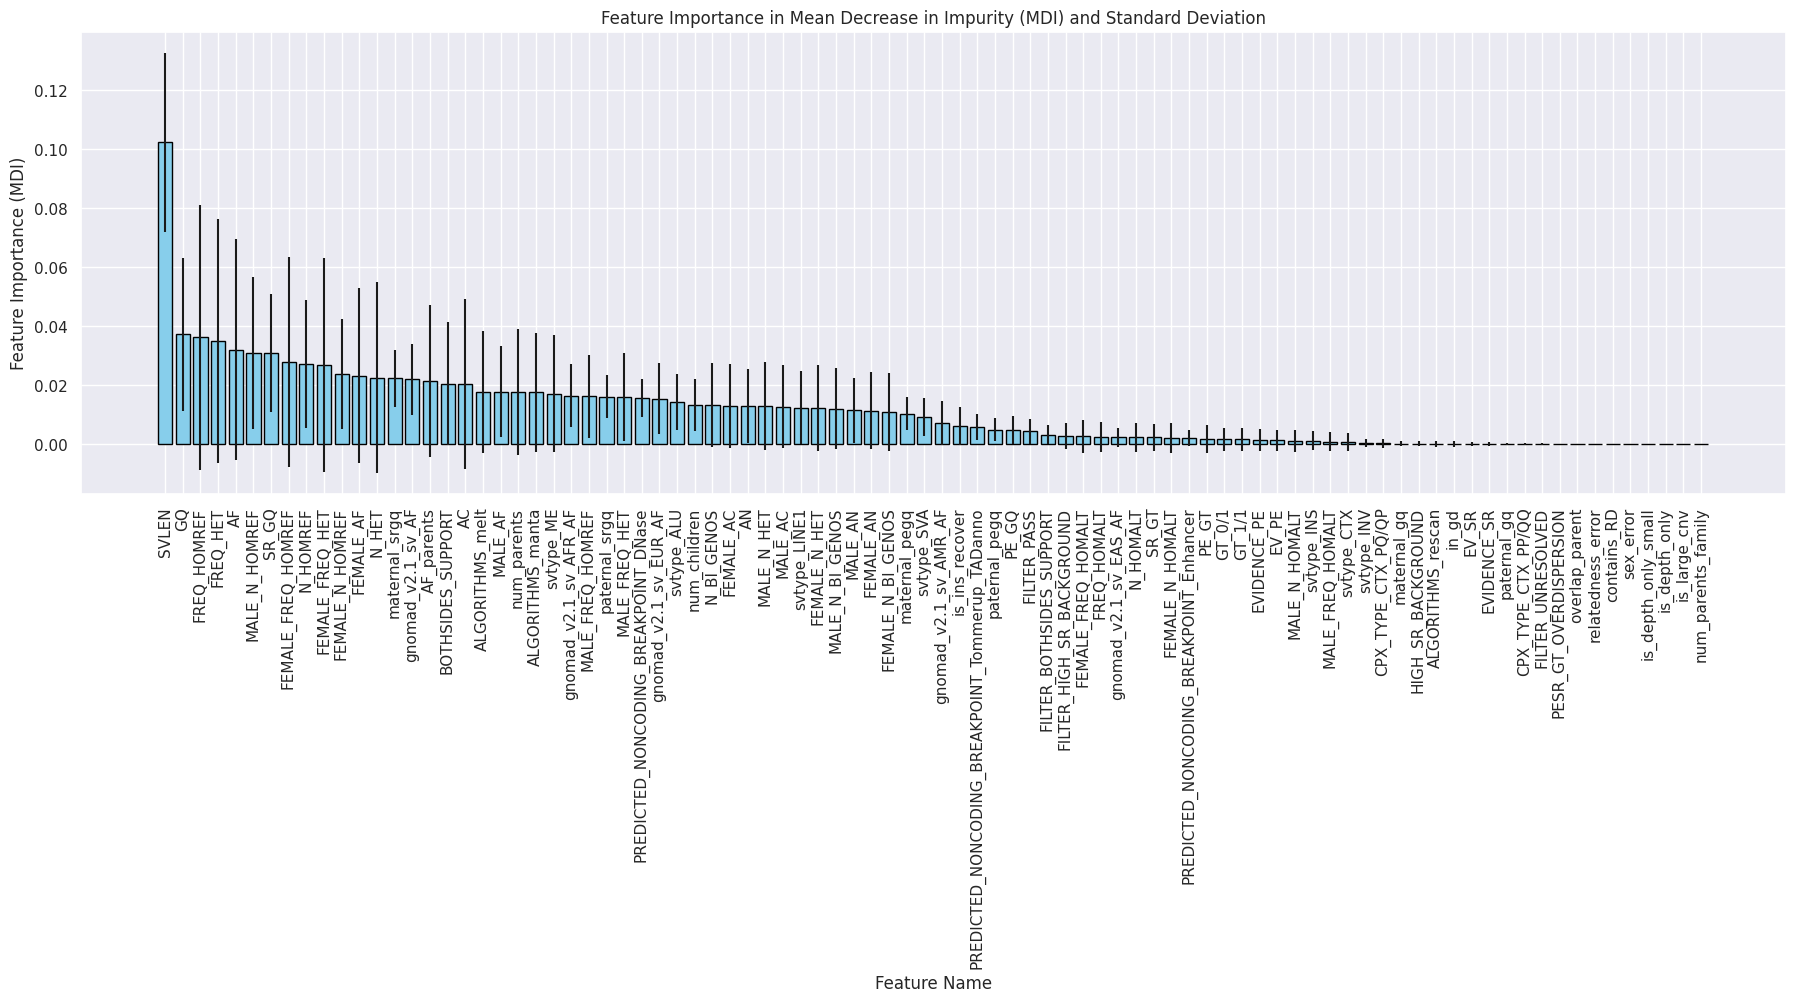

In [944]:
plt.figure(figsize=(22, 6))
feature_importances_df = feature_importances_df.sort_values(by='feature_importance', ascending=False)
plt.bar(feature_importances_df['feature_name'], feature_importances_df['feature_importance'], yerr=feature_importances_df['std'], color='skyblue', edgecolor='black')
# sns.barplot(feature_importances_df, x="feature_name", y="feature_importance", errorbar="sd")

# Rotate the x-axis labels for better readability
plt.xticks(rotation=90)

# Labels and title
plt.xlabel('Feature Name')
plt.ylabel('Feature Importance (MDI)')
plt.title('Feature Importance in Mean Decrease in Impurity (MDI) and Standard Deviation')

# ax.set_title("Feature importances in \nMean Decrease in Impurity (MDI)")
# ax.set_ylabel("Feature name")
# ax.set_xlabel("MDI importance")

## SHAP Model Explanation

In [945]:
# explainer = shap.TreeExplainer(rfc)

In [946]:
# shap_values = explainer.shap_values(x_test)

In [947]:
# shap_values_class_0 = shap_values[:, :, 0]
# shap.summary_plot(shap_values_class_0, x_test, show=False)
# plt.title(r"SHAP Values for the Not ${\it de\ novo}$ Variants on the Test Set")
# plt.show()

In [948]:
# shap_values_class_1 = shap_values[:, :, 1]
# shap.summary_plot(shap_values_class_1, x_test, show=False)
# plt.title(r"SHAP Values for the ${\it de\ novo}$ Variants on the Test Set")
# plt.show()

In [949]:
# shap_values_subsample = explainer(x_test.sample(n=100, random_state=11))
# shap_values_subsample_class_1 = shap_values_subsample[:, :, 1]
# shap.plots.heatmap(shap_values_subsample_class_1, feature_values=shap_values_subsample_class_1.abs.max(0), cmap="viridis")

In [950]:
# shap_values = explainer.shap_values(x_test)
# shap_values_class_1 = shap_values[:, :, 1]
# shap.plots.violin(shap_values_class_1, feature_names=list(x_test.columns))

In [951]:
# x["SVLEN"].hist()

# Model: Linear Regression

In [952]:
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)

LinearRegression()

In [953]:
def get_lr_predictions(x, y):
  rf_preds = lr_model.predict(x)[:, 1]
  rf_preds_discretized = vectorized_discretize(rf_preds)

  preds = x.copy()
  preds["y"] = y
  preds[rf_column] = rf_preds
  preds[rf_column + disc_col_postfix] = rf_preds_discretized

  return preds

In [954]:
# Predictions
# predictions = model.predict(X)
# xyz = get_lr_predictions(x_train, y_train)